In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from scipy.signal import medfilt, convolve, welch

In [2]:
readings = pd.read_csv("outputs with 100 trials/Vergence_Combined_Calculation_of_Molindu​_20250204163331.csv")
readings = readings.drop_duplicates()
readings

,video file name,frame number,timestamp (s),ML model,pupil left radius,pupil right radius,vergence from direction in radians,vergence from direction in degrees,vergence from gaze arrows in radians,vergence from gaze arrows in degrees
0,output_compressed_20250204163331.mp4,1,0.000000,WC Analysis,12,13,0.411597,23.582773,0.091977,5.269869
1,output_compressed_20250204163331.mp4,2,0.016683,WC Analysis,12,13,0.376083,21.547992,0.102959,5.899125
2,output_compressed_20250204163331.mp4,3,0.033367,WC Analysis,12,13,0.401034,22.977577,0.095899,5.494600
3,output_compressed_20250204163331.mp4,4,0.050050,WC Analysis,12,13,0.401034,22.977577,0.095899,5.494600
4,output_compressed_20250204163331.mp4,5,0.066733,WC Analysis,12,13,0.401034,22.977577,0.095899,5.494600
...,...,...,...,...,...,...,...,...,...,...
24355,output_compressed_20250204163331.mp4,24356,406.322611,WC Analysis,11,10,0.395524,22.661844,0.055448,3.176908
24356,output_compressed_20250204163331.mp4,24357,406.339294,WC Analysis,11,10,0.392483,22.487620,0.056405,3.231787
24357,output_compressed_20250204163331.mp4,24358,406.355978,WC Analysis,11,10,0.392483,22.487620,0.056397,3.231336
24358,output_compressed_20250204163331.mp4,24359,406.372661,WC Analysis,11,10,0.392483,22.487620,0.056397,3.231336


In [3]:
full_signal = np.array(readings['vergence from gaze arrows in degrees'])
full_time = np.array(readings['timestamp (s)'])

In [4]:
def moving_average_filter(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return convolve(data, window, mode='valid')

In [5]:
median_window_size = 31
moving_avg_window_size = 31

moving_median_filtered_signal = medfilt(full_signal, kernel_size=median_window_size)
moving_median_avg_filtered_signal = moving_average_filter(moving_median_filtered_signal, window_size=moving_avg_window_size)

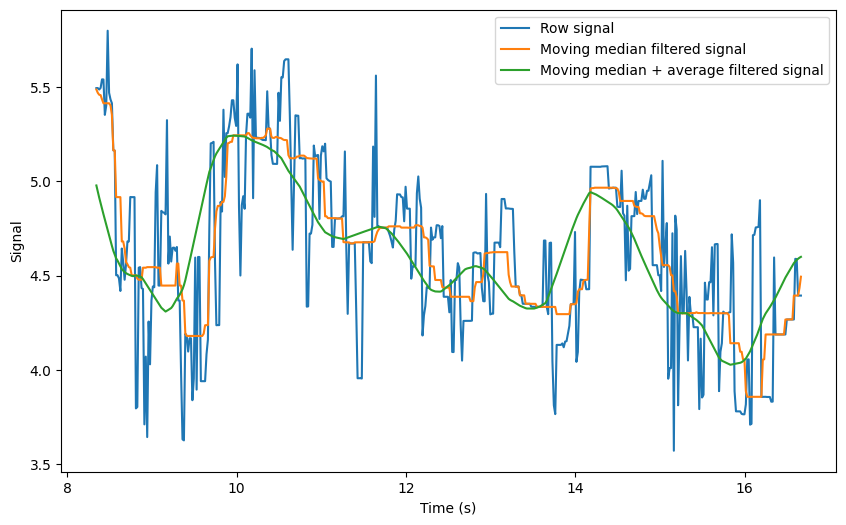

In [6]:
a = 500
b = 1000
plt.figure(figsize=(10, 6))
plt.plot(full_time[a:b], full_signal[a:b], label='Row signal')
plt.plot(full_time[a:b], moving_median_filtered_signal[a:b], label='Moving median filtered signal')
plt.plot(full_time[a:b], moving_median_avg_filtered_signal[a:b], label='Moving median + average filtered signal')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.legend()
plt.show()

In [7]:
def find_closest_index(time):
    # find the closest index in the full_time array to the given time in MILLISECONDS
    closest_index = np.argmin(np.abs(time - full_time * 1000))
    return closest_index

find_closest_index(401830)

np.int64(24086)

In [8]:
# load json file content
with open(r'data with 100 trials/Molindu_20250204163331/StimuliResponseData_20250204163331.json') as f:
    data = json.load(f)

In [9]:
game_data_df = pd.DataFrame(data['fruitTimings'])

In [10]:
game_data_df

,fruit,type,appeared,disappeared
0,pear,Normal,00:00:02.030,00:00:04.064
1,pear,Normal,00:00:06.097,00:00:08.131
2,pear,Normal,00:00:10.164,00:00:12.196
3,pear,Normal,00:00:14.230,00:00:16.262
4,grapes,Abnormal,00:00:18.296,00:00:20.329
...,...,...,...,...
95,pear,Normal,00:06:28.220,00:06:30.253
96,pear,Normal,00:06:32.286,00:06:34.319
97,pear,Normal,00:06:36.352,00:06:38.384
98,grapes,Abnormal,00:06:40.418,00:06:42.449


In [11]:
# convert hour:minute:seconds:milliseconds time to milliseonds

def convert_time_to_milliseconds(time_str):
    time_parts = time_str.split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds, milliseconds = time_parts[2].split('.')
    seconds = int(seconds)
    milliseconds = int(milliseconds)

    total_milliseconds = (hours * 3600 + minutes * 60 + seconds) * 1000 + milliseconds
    return total_milliseconds

convert_time_to_milliseconds(game_data_df.appeared[99])

404482

In [ ]:
sampling_rate = 60
time_backward = 0.5
time_forward = 1
points_back = int(sampling_rate * time_backward)
points_forward = int(sampling_rate * time_forward)

appeared_indexes = []
vergence_responses = []
for times in game_data_df.appeared.tolist():
    closest_index = find_closest_index(convert_time_to_milliseconds(times))
    appeared_indexes.append(closest_index)

    vergence_response = moving_median_avg_filtered_signal[closest_index-points_back:closest_index+points_forward]
    baseline_corrected_vergence_response = vergence_response - np.mean(vergence_response[:45])
    vergence_responses.append(baseline_corrected_vergence_response)
   

game_data_df['appeared_index'] = appeared_indexes

In [13]:
game_data_df

,fruit,type,appeared,disappeared,appeared_index
0,pear,Normal,00:00:02.030,00:00:04.064,122
1,pear,Normal,00:00:06.097,00:00:08.131,365
2,pear,Normal,00:00:10.164,00:00:12.196,609
3,pear,Normal,00:00:14.230,00:00:16.262,853
4,grapes,Abnormal,00:00:18.296,00:00:20.329,1097
...,...,...,...,...,...
95,pear,Normal,00:06:28.220,00:06:30.253,23270
96,pear,Normal,00:06:32.286,00:06:34.319,23514
97,pear,Normal,00:06:36.352,00:06:38.384,23757
98,grapes,Abnormal,00:06:40.418,00:06:42.449,24001


In [14]:
vergence_array = pd.DataFrame(vergence_responses)
vergence_array.columns = [f'v_{i}' for i in range(vergence_array.shape[1])]

game_data_df = pd.concat([game_data_df, vergence_array], axis=1)

In [15]:
game_data_df

,fruit,type,appeared,disappeared,appeared_index,v_0,v_1,v_2,v_3,v_4,...,v_110,v_111,v_112,v_113,v_114,v_115,v_116,v_117,v_118,v_119
0,pear,Normal,00:00:02.030,00:00:04.064,122,-0.045529,-0.049512,-0.053495,-0.057478,-0.060781,...,-0.216604,-0.205389,-0.194173,-0.182045,-0.169918,-0.157790,-0.145625,-0.138048,-0.135195,-0.132343
1,pear,Normal,00:00:06.097,00:00:08.131,365,-0.027749,-0.016598,-0.006426,0.003717,0.013809,...,0.612322,0.610931,0.609539,0.608147,0.606756,0.604933,0.600151,0.589270,0.578348,0.559412
2,pear,Normal,00:00:10.164,00:00:12.196,609,0.139298,0.135372,0.131757,0.128549,0.125341,...,-0.456384,-0.466661,-0.478501,-0.490316,-0.502162,-0.514007,-0.525853,-0.537699,-0.549943,-0.562188
3,pear,Normal,00:00:14.230,00:00:16.262,853,0.195366,0.192065,0.187677,0.183289,0.178772,...,-0.639771,-0.622434,-0.605083,-0.587732,-0.570381,-0.551700,-0.531118,-0.510246,-0.489374,-0.468501
4,grapes,Abnormal,00:00:18.296,00:00:20.329,1097,-0.116247,-0.119226,-0.122206,-0.125185,-0.126666,...,-0.333319,-0.348263,-0.363206,-0.378150,-0.393076,-0.408002,-0.422078,-0.436060,-0.448526,-0.459305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,pear,Normal,00:06:28.220,00:06:30.253,23270,0.125223,0.126307,0.126015,0.122443,0.118872,...,-0.019277,-0.022698,-0.026118,-0.029539,-0.032958,-0.036193,-0.039428,-0.039910,-0.038886,-0.037862
96,pear,Normal,00:06:32.286,00:06:34.319,23514,0.414815,0.402596,0.390376,0.376822,0.362998,...,0.502446,0.477948,0.453450,0.428954,0.404457,0.379960,0.355464,0.330967,0.306470,0.281973
97,pear,Normal,00:06:36.352,00:06:38.384,23757,0.179569,0.204323,0.229077,0.249637,0.268041,...,0.199941,0.198952,0.197962,0.196016,0.193456,0.190886,0.188311,0.185359,0.193377,0.201401
98,grapes,Abnormal,00:06:40.418,00:06:42.449,24001,-0.215506,-0.201854,-0.188073,-0.174291,-0.159900,...,0.471133,0.470361,0.469590,0.468834,0.464602,0.469364,0.474126,0.482407,0.490804,0.501234


In [16]:
# function to calculate the power of a signal within the frequency range 5Hz to 30Hz
def compute_power(signal, fs, fmin, fmax):
    
    freqs, psd = welch(signal, fs=fs, nperseg=90)
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    power = np.trapezoid(psd[idx_band], freqs[idx_band])
    
    return power

# compute the mean based on the first n trials with the lowest noise power
def compute_mean_of_first_n_low_power_trials(fruit, sampling_rate, fmin, fmax, number_of_trials= None):
    sorted_df = game_data_df[game_data_df['fruit'] == fruit].assign(
        power=lambda df: df.iloc[:, 5:].apply(lambda row: compute_power(row.values, sampling_rate, fmin, fmax), axis=1)
    ).sort_values(by='power')

    return sorted_df.iloc[:number_of_trials, 5:-1].mean()   # index 5 is the v_0 and index -1 is the power

In [17]:
def plot_mean_signals(n_low_power_signals = None, fmin = 5, fmax= 30):
    time_axis = [(i-points_back)/sampling_rate for i in range(points_back+points_forward)]

    pear_mean_response = compute_mean_of_first_n_low_power_trials ('pear', sampling_rate,fmin, fmax, n_low_power_signals)
    orange_mean_response = compute_mean_of_first_n_low_power_trials ('orange', sampling_rate,fmin, fmax, n_low_power_signals)
    grapes_mean_response = compute_mean_of_first_n_low_power_trials('grapes', sampling_rate,fmin, fmax, n_low_power_signals)

    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, pear_mean_response, label = 'Pear')
    plt.plot(time_axis, orange_mean_response, label = 'Orange')
    plt.plot(time_axis, grapes_mean_response, label='Grapes')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f"Mean vergence responses for each fruit {'' if n_low_power_signals is None else f'with first {n_low_power_signals} low power trials'}")
    plt.xlabel("Time (s)")
    plt.ylabel("Relative vergence in degrees")
    plt.legend()
    plt.show()

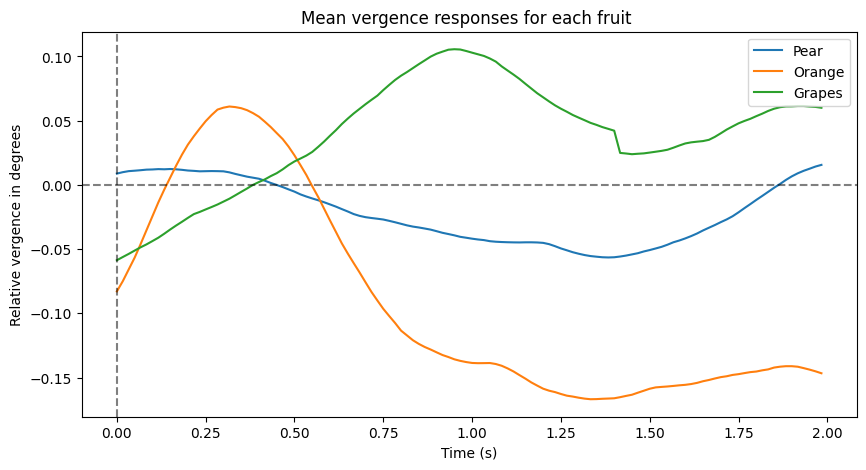

In [18]:
plot_mean_signals()

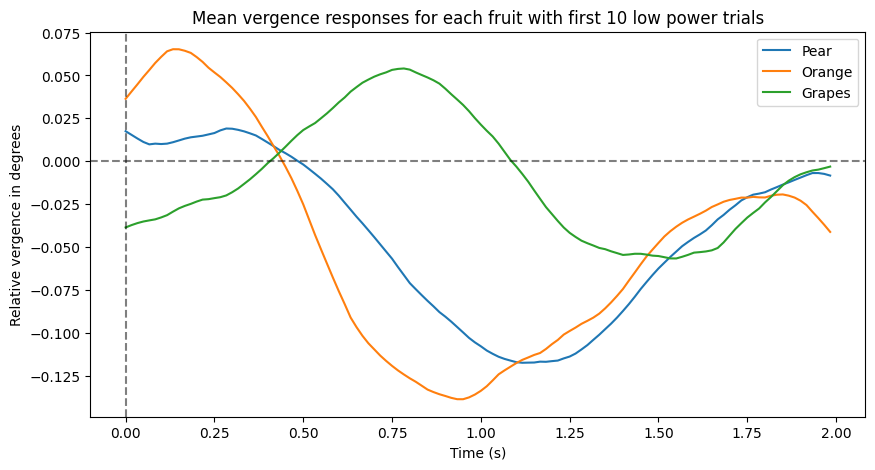

In [19]:
plot_mean_signals(n_low_power_signals=10, fmin=2)